In [1]:
import tensorflow as tf 
import plotly as px
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [2]:
df = pd.read_csv(r'D:\Time_series_project\data_material.csv')
df_time = df.set_index('Date')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2787 entries, 0 to 2786
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Currency             2787 non-null   object 
 1   Date                 2787 non-null   object 
 2   Closing Price (USD)  2787 non-null   float64
 3   24h Open (USD)       2787 non-null   float64
 4   24h High (USD)       2787 non-null   float64
 5   24h Low (USD)        2787 non-null   float64
dtypes: float64(4), object(2)
memory usage: 130.8+ KB


In [3]:
df_time.tail()

,Currency,Closing Price (USD),24h Open (USD),24h High (USD),24h Low (USD)
Date,,,,,
2021-05-14,BTC,49764.132082,49596.778891,51448.798576,46294.720180
2021-05-15,BTC,50032.693137,49717.354353,51578.312545,48944.346536
2021-05-16,BTC,47885.625255,49926.035067,50690.802950,47005.102292
2021-05-17,BTC,45604.615754,46805.537852,49670.414174,43868.638969
2021-05-18,BTC,43144.471291,46439.336570,46622.853437,42102.346430


In [4]:
import plotly.express as px

fig = px.line(df, x='Date', y='Closing Price (USD)', title="BitCoin Adj closed price")
fig.update_xaxes(
    rangeslider_visible=True,
    rangeselector=dict(
        buttons=list([
            dict(count=1, label="1m", step="month", stepmode="backward"),
            dict(count=6, label="6m", step="month", stepmode="backward"),
            dict(count=1, label="YTD", step="year", stepmode="todate"),
            dict(count=1, label="1y", step="year", stepmode="backward"),
            dict(step="all")
        ])
    )
)
fig.show()


array([<Axes: xlabel='Date'>, <Axes: xlabel='Date'>,
       <Axes: xlabel='Date'>, <Axes: xlabel='Date'>], dtype=object)

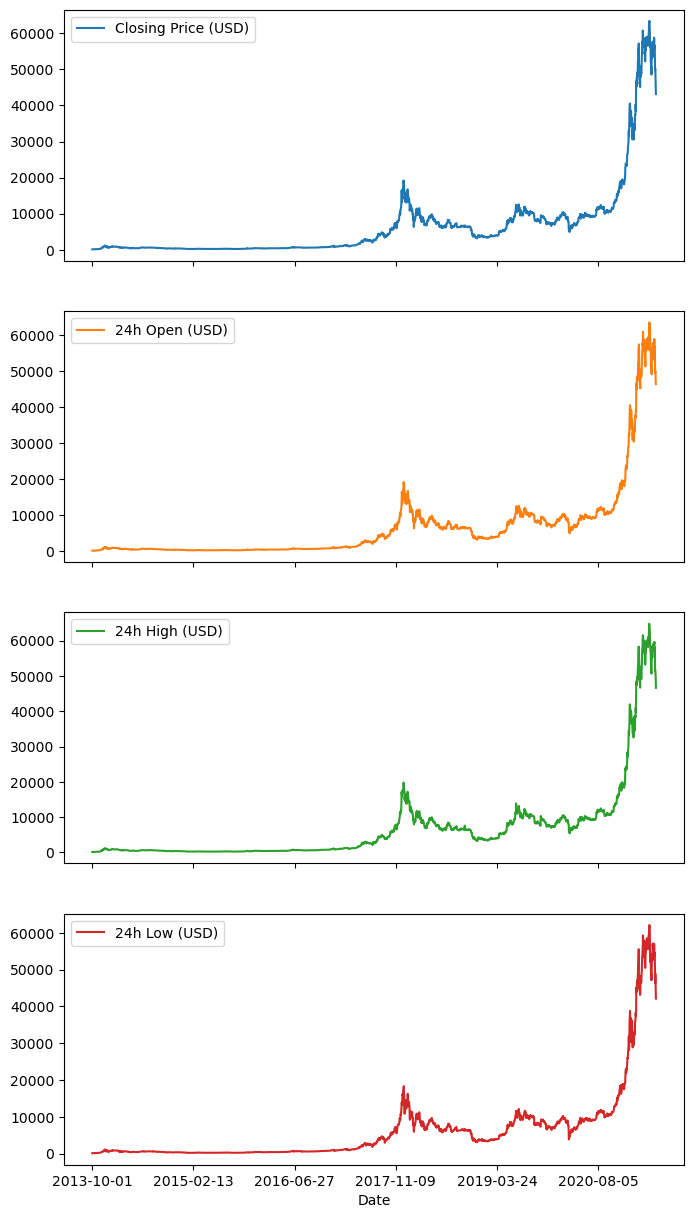

In [186]:
df_time.plot(subplots = True,figsize = (8,15))

In [5]:
bitcoin_price = pd.DataFrame(df_time['Closing Price (USD)']).rename(columns = {'Closing Price (USD)': 'PRice'})
bitcoin_price.head()

,PRice
Date,
2013-10-01,123.65499
2013-10-02,125.45500
2013-10-03,108.58483
2013-10-04,118.67466
2013-10-05,121.33866


In [6]:
timestemp = bitcoin_price.index.to_numpy()
price = bitcoin_price['PRice'].to_numpy()
timestamp = pd.to_datetime(timestemp)

In [7]:
split_size = int(0.85*len(price))
x_train, y_train = timestamp[:split_size], price[:split_size]
x_test, y_test = timestamp[split_size:], price[split_size:]
len(x_train), len(y_train), len(x_test), len(y_test)

(2368, 2368, 419, 419)

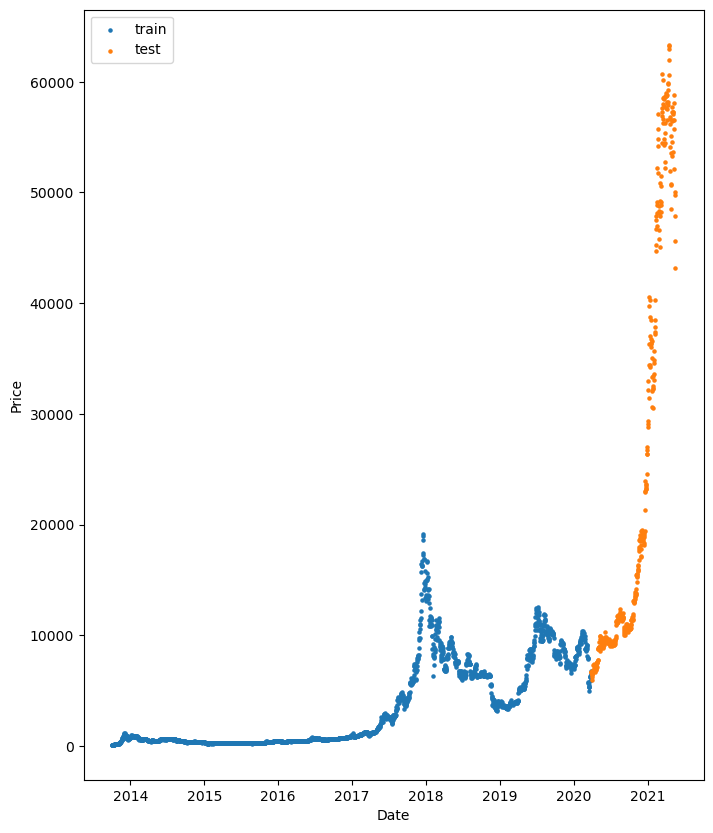

In [190]:
plt.figure(figsize = (8,10))
plt.scatter(x_train, y_train,s=5,label = 'train')
plt.scatter(x_test, y_test,s=5, label ='test')
plt.legend()

plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

In [191]:
def plot_time_series(timestemps, values, format= ".", start = 0, end = None, label = None):
    plt.plot(timestemps[start:end], values[start:end], format, label = label)
    plt.xlabel("Time")
    plt.ylabel("Value")
    if label:
        plt.legend(fontsize = 14)
    plt.grid(True)

In [192]:
y_test[:10], y_test[-10:]

(array([6706.98508913, 6721.49539238, 6682.7800492 , 6229.48834283,
        5922.48983509, 6483.73944553, 6446.42134684, 6537.3364615 ,
        6850.55871169, 6776.37009357]),
 array([58788.20967893, 58102.19142623, 55715.54665129, 56573.5554719 ,
        52147.82118698, 49764.1320816 , 50032.69313676, 47885.62525472,
        45604.61575361, 43144.47129086]))

### Naive approach 

In [193]:

naive_forecast = y_test[:-1]

naive_forecast[:10], naive_forecast[-10:]

(array([6706.98508913, 6721.49539238, 6682.7800492 , 6229.48834283,
        5922.48983509, 6483.73944553, 6446.42134684, 6537.3364615 ,
        6850.55871169, 6776.37009357]),
 array([57107.12067189, 58788.20967893, 58102.19142623, 55715.54665129,
        56573.5554719 , 52147.82118698, 49764.1320816 , 50032.69313676,
        47885.62525472, 45604.61575361]))

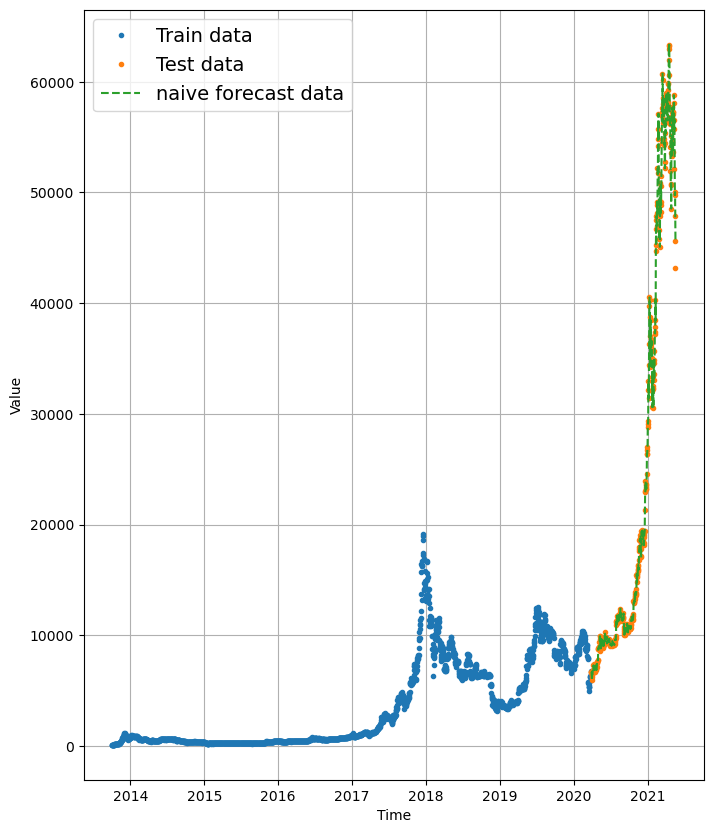

In [194]:
plt.figure(figsize = (8,10))
plot_time_series(timestemps= x_train, values= y_train, label = 'Train data')
plot_time_series(timestemps= x_test, values= y_test, label = 'Test data')
plot_time_series(timestemps= x_test[1:], values= naive_forecast,format = '--', label = 'naive forecast data')

In [195]:
def mean_absolute_scaled_error(y_true, y_pred, seasonality=1):
    mae = np.mean(np.abs(y_true - y_pred))
    naive_forecast = y_true[:-seasonality]
    naive_mae = np.mean(np.abs(naive_forecast - y_true[seasonality:]))
    mase = mae / naive_mae
    return mase

def evaluate_preds(y_true, y_pred,seasonality=1):
    y_true = tf.cast(y_true, dtype=tf.float32)
    y_pred = tf.cast(y_pred, dtype=tf.float32)

    mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
    mse = tf.keras.metrics.mean_squared_error(y_true, y_pred)
    rmse = tf.sqrt(mse)
    huber_loss = tf.keras.losses.Huber()(y_true, y_pred)

    mase = mean_absolute_scaled_error(y_true.numpy(), y_pred.numpy(),seasonality=1)
    print("For mae, mse, rmse and hubber : lower value is better.\nmase :- A scaled eror is >1 if the forecast is worse than the naive and <1 if the forecast is better that the naive.")
    print(f"""
    "mae": {mae.numpy()},
    "mse": {mse.numpy()},
    "rmse": {rmse.numpy()},
    "huber_loss": {huber_loss.numpy()},
    "mase": {mase}
    """)
    return {
        "mae": mae.numpy(),
        "mse": mse.numpy(),
        "rmse": rmse.numpy(),
        "huber_loss": huber_loss.numpy(),
        "mase": mase
    }




In [196]:
maive_result = evaluate_preds(y_true= y_test[1:], y_pred = naive_forecast)


For mae, mse, rmse and hubber : lower value is better.
mase :- A scaled eror is >1 if the forecast is worse than the naive and <1 if the forecast is better that the naive.

    "mae": 691.0709228515625,
    "mse": 1496519.5,
    "rmse": 1223.3231201171875,
    "huber_loss": 690.5709228515625,
    "mase": 0.9976577162742615
    


mase :- A scaled eror is >1 if the forecast is worse than the naive and <1 if the forecast is better that the naive.

### Now function for data preparation for deep learning models

In [197]:
def get_labelled_window(x,horizon = 1):
    return x[:, :-horizon], x[:,-horizon]

In [198]:
tf.range(8)+1

<tf.Tensor: shape=(8,), dtype=int32, numpy=array([1, 2, 3, 4, 5, 6, 7, 8])>

In [199]:
tf.expand_dims(tf.range(8)+1, axis = 0)

<tf.Tensor: shape=(1, 8), dtype=int32, numpy=array([[1, 2, 3, 4, 5, 6, 7, 8]])>

In [200]:
test_window, test_label = get_labelled_window(tf.expand_dims(tf.range(8)+1, axis = 0))
print(f"Window :{tf.squeeze(test_window).numpy()} --> Label :{tf.squeeze(test_label).numpy()}")

Window :[1 2 3 4 5 6 7] --> Label :8


In [201]:
def get_labelled_window(x, horizon=1):
    return x[:, :-horizon], x[:, -horizon:]



def make_windows(x,window_size,horizon):
    #Create a window of specific window size (add the horizon to the end of the window for fuether labelling)
    window_step = np.expand_dims(np.arange(window_size+horizon), axis =0)
    # print(window_step)
    # create a 2D array of multiple window steps(minus 1 to account for 0 indexing)
    window_indexes = window_step + np.expand_dims(np.arange(len(x)- (window_size+horizon -1)),axis = 0).T
    # print(window_indexes)

    windowed_array = x[window_indexes]

    windows, labels = get_labelled_window(windowed_array,horizon=horizon )

    return windows, labels

In [202]:
full_windows, full_labels = make_windows(price, window_size = 7, horizon=1)
for i in range(0,3,1):
    print(f"window : {full_windows[i]} -> Label : {full_labels[i]})")

window : [123.65499 125.455   108.58483 118.67466 121.33866 120.65533 121.795  ] -> Label : [123.033])
window : [125.455   108.58483 118.67466 121.33866 120.65533 121.795   123.033  ] -> Label : [124.049])
window : [108.58483 118.67466 121.33866 120.65533 121.795   123.033   124.049  ] -> Label : [125.96116])


In [203]:
# We can also use TimeseriesGenerator to generate windows and labels  for each window and each       
# from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
# win_length = 720 # for 5 days of data (6*24*5)
# batch_size = 32
# num_features = 4
# train_generator = TimeseriesGenerator(X_train,Y_train,length= win_length, sampling_rate=1,batch_size=batch_size)
# test_generator = TimeseriesGenerator(X_test,Y_test,length= win_length, sampling_rate=1,batch_size=batch_size)


### Turning data into train data and test data

In [204]:
def make_train_test_splits(windows, labels, test_split = 0.2):
    split_size = int(len(windows)* (1-test_split))
    train_windows = windows[:split_size]
    train_labels = labels[:split_size]
    test_windows = windows[split_size:]
    test_labels = labels[split_size:]
    return train_windows, test_windows, train_labels, test_labels

In [205]:
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(full_windows, full_labels)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2224, 556, 2224, 556)

### Make modelling check points(using tensorboard)

In [206]:
import os
def create_model_checkpoints(model_name, save_path="model_experiments"):
    return tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(save_path, model_name),
                                               verbose=0,
                                               save_best_only=True)


## Model 1 (window = 7, horizon = 1)

In [207]:
import tensorflow
from tensorflow import keras
from keras import Sequential
from keras.layers import Dense
from tensorflow.keras.layers import BatchNormalization, Dropout

In [208]:
train_windows.shape

(2224, 7)

In [209]:
model1 = Sequential()

model1.add(Dense(128,activation='relu',input_dim = 7))
model1.add(BatchNormalization())
model1.add(Dropout(0.25))
model1.add(Dense(64,activation='relu'))
model1.add(BatchNormalization())
model1.add(Dropout(0.25))
model1.add(Dense(1,activation='linear'))

model1.summary()

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_51 (Dense)            (None, 128)               1024      
                                                                 
 batch_normalization_31 (Bat  (None, 128)              512       
 chNormalization)                                                
                                                                 
 dropout_19 (Dropout)        (None, 128)               0         
                                                                 
 dense_52 (Dense)            (None, 64)                8256      
                                                                 
 batch_normalization_32 (Bat  (None, 64)               256       
 chNormalization)                                                
                                                                 
 dropout_20 (Dropout)        (None, 64)              

In [210]:
model1.compile(loss = 'mae', optimizer='Adam',metrics=['mae'])

In [211]:
model1.fit(train_windows, train_labels, 
            epochs=100, verbose=1, 
            batch_size= 32, validation_data=(test_windows, test_labels),
            callbacks = [create_model_checkpoints(model_name=model1.name)])

Epoch 1/100
62/70 [=========================>....] - ETA: 0s - loss: 3158.3579 - mae: 3158.3579

INFO:tensorflow:Assets written to: model_experiments\sequential_17\assets
70/70 [==============================] - 2s 22ms/step - loss: 3157.9963 - mae: 3157.9963 - val_loss: 20101.7676 - val_mae: 20101.7676
Epoch 2/100
70/70 [==============================] - 0s 6ms/step - loss: 3156.8540 - mae: 3156.8540 - val_loss: 20104.9922 - val_mae: 20104.9922
Epoch 3/100
70/70 [==============================] - 0s 6ms/step - loss: 3154.7458 - mae: 3154.7458 - val_loss: 20107.7969 - val_mae: 20107.7969
Epoch 4/100
70/70 [==============================] - 1s 19ms/step - loss: 3151.1980 - mae: 3151.1980 - val_loss: 20101.7090 - val_mae: 20101.7090
Epoch 5/100
70/70 [==============================] - 1s 21ms/step - loss: 3145.8779 - mae: 3145.8779 - val_loss: 20086.5312 - val_mae: 20086.5312
Epoch 6/100
70/70 [==============================] - 0s 6ms/step - loss: 3138.8586 - mae: 3138.8586 - val_loss: 20090.0293 - val_mae: 20090.0293
Epoch 7/100
70/70 [==============================] - 1s 21ms/step

In [212]:
forecast  = model1.predict(test_windows)
preds = tf.squeeze(forecast)
model1_result = evaluate_preds(y_true= tf.squeeze(test_labels), y_pred = preds)

 1/18 [>.............................] - ETA: 1s

18/18 [==============================] - 0s 2ms/step
For mae, mse, rmse and hubber : lower value is better.
mase :- A scaled eror is >1 if the forecast is worse than the naive and <1 if the forecast is better that the naive.

    "mae": 6527.40771484375,
    "mse": 115315048.0,
    "rmse": 10738.484375,
    "huber_loss": 6526.90771484375,
    "mase": 11.466848373413086
    


### Model_2 (Window size = 30, horizon = 1)

In [213]:
window_size = 30
horizon = 1
full_windows, full_labels = make_windows(price, window_size=window_size, horizon=horizon)
len(full_windows),len(full_labels)

(2757, 2757)

In [214]:
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(full_windows, full_labels)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2205, 552, 2205, 552)

In [215]:
window_size = 30
horizon = 1
model2 = Sequential()
# 1st hidden layer
model2.add(Dense(128,activation='relu',input_dim = window_size))
model2.add(BatchNormalization())
model2.add(Dropout(0.25))
# 2nd hidden layer
model2.add(Dense(64,activation='relu'))
model2.add(BatchNormalization())
model2.add(Dropout(0.25))
# 3rd hidden layer
model2.add(Dense(32,activation='relu'))
model2.add(BatchNormalization())
model2.add(Dropout(0.25))

model2.add(Dense(horizon,activation='linear'))


model2.compile(loss = 'mae', optimizer='Adam',metrics=['mae'])

model2.fit(train_windows, train_labels, 
            epochs=100, verbose=1, 
            batch_size= 32, validation_data=(test_windows, test_labels),
            callbacks = [create_model_checkpoints(model_name=model2.name)])

Epoch 1/100


69/69 [==============================] - 3s 28ms/step - loss: 3199.7751 - mae: 3199.7751 - val_loss: 20179.8418 - val_mae: 20179.8418
Epoch 2/100
69/69 [==============================] - 2s 35ms/step - loss: 3199.0994 - mae: 3199.0994 - val_loss: 20175.1406 - val_mae: 20175.1406
Epoch 3/100
69/69 [==============================] - 2s 27ms/step - loss: 3198.0032 - mae: 3198.0032 - val_loss: 20171.7598 - val_mae: 20171.7598
Epoch 4/100
69/69 [==============================] - 2s 26ms/step - loss: 3196.1790 - mae: 3196.1790 - val_loss: 20165.0625 - val_mae: 20165.0625
Epoch 5/100
69/69 [==============================] - 0s 7ms/step - loss: 3193.5723 - mae: 3193.5723 - val_loss: 20165.2695 - val_mae: 20165.2695
Epoch 6/100
69/69 [==============================] - 2s 26ms/step - loss: 3190.1724 - mae: 3190.1724 - val_loss: 20153.7109 - val_mae: 20153.7109
Epoch 7/100
69/69 [==============================] - 2s 26ms/step - loss: 3185.8958 - mae: 3185.8958 - val_loss: 20148.2227 - val_mae: 20

In [216]:

forecast  = model2.predict(test_windows)
preds = tf.squeeze(forecast)
model1_result = evaluate_preds(y_true= tf.squeeze(test_labels), y_pred = preds)

18/18 [==============================] - 0s 2ms/step
For mae, mse, rmse and hubber : lower value is better.
mase :- A scaled eror is >1 if the forecast is worse than the naive and <1 if the forecast is better that the naive.

    "mae": 15562.705078125,
    "mse": 528881824.0,
    "rmse": 22997.4296875,
    "huber_loss": 15562.205078125,
    "mase": 27.203760147094727
    


### moddel_3 (window_size = 7, horizon = 1)

In [217]:
window_size = 7
horizon = 1
full_windows, full_labels = make_windows(price, window_size=window_size, horizon=horizon)
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(full_windows, full_labels)


In [218]:

model3 = Sequential()
# 1st hidden layer
model3.add(Dense(128,activation='relu',input_dim = window_size))
model3.add(BatchNormalization())
model3.add(Dropout(0.25))
# 2nd hidden layer
model3.add(Dense(64,activation='relu'))
model3.add(BatchNormalization())
model3.add(Dropout(0.25))
# 3rd hidden layer
model3.add(Dense(32,activation='relu'))
model3.add(BatchNormalization())
model3.add(Dropout(0.25))

model3.add(Dense(horizon,activation='linear'))


model3.compile(loss = 'mae', optimizer='Adam',metrics=['mae'])

model3.fit(train_windows, train_labels, 
            epochs=100, verbose=1, 
            batch_size= 32, validation_data=(test_windows, test_labels),
            callbacks = [create_model_checkpoints(model_name=model3.name)])

Epoch 1/100


70/70 [==============================] - 3s 27ms/step - loss: 3158.0881 - mae: 3158.0881 - val_loss: 20090.6289 - val_mae: 20090.6289
Epoch 2/100
70/70 [==============================] - 2s 26ms/step - loss: 3157.3684 - mae: 3157.3684 - val_loss: 20086.8965 - val_mae: 20086.8965
Epoch 3/100
70/70 [==============================] - 2s 35ms/step - loss: 3156.1440 - mae: 3156.1440 - val_loss: 20085.3320 - val_mae: 20085.3320
Epoch 4/100
70/70 [==============================] - 2s 27ms/step - loss: 3154.2183 - mae: 3154.2183 - val_loss: 20078.7871 - val_mae: 20078.7871
Epoch 5/100
70/70 [==============================] - 0s 7ms/step - loss: 3151.4565 - mae: 3151.4565 - val_loss: 20079.5801 - val_mae: 20079.5801
Epoch 6/100
70/70 [==============================] - 0s 7ms/step - loss: 3147.9062 - mae: 3147.9062 - val_loss: 20080.8730 - val_mae: 20080.8730
Epoch 7/100
70/70 [==============================] - 2s 25ms/step - loss: 3143.4890 - mae: 3143.4890 - val_loss: 20067.3613 - val_mae: 200

In [219]:

forecast  = model3.predict(test_windows)
preds = tf.squeeze(forecast)
model1_result = evaluate_preds(y_true= tf.squeeze(test_labels), y_pred = preds)

 1/18 [>.............................] - ETA: 1s

18/18 [==============================] - 0s 2ms/step
For mae, mse, rmse and hubber : lower value is better.
mase :- A scaled eror is >1 if the forecast is worse than the naive and <1 if the forecast is better that the naive.

    "mae": 15260.884765625,
    "mse": 528254816.0,
    "rmse": 22983.794921875,
    "huber_loss": 15260.384765625,
    "mase": 26.809146881103516
    


In [220]:
df['Date'][-len(preds):]

2231    2019-11-10
2232    2019-11-11
2233    2019-11-12
2234    2019-11-13
2235    2019-11-14
           ...    
2782    2021-05-14
2783    2021-05-15
2784    2021-05-16
2785    2021-05-17
2786    2021-05-18
Name: Date, Length: 556, dtype: object

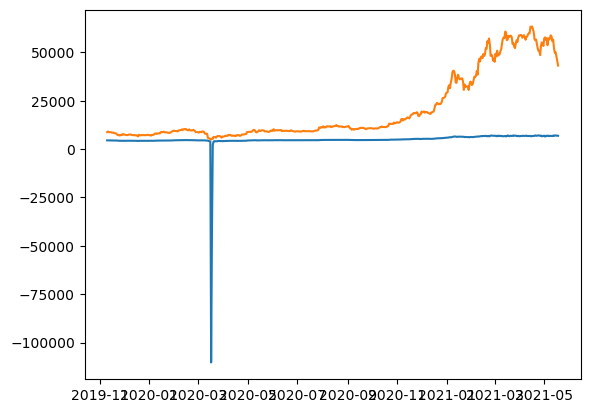

In [221]:
plt.figure()
plt.plot(pd.to_datetime(df['Date'][-len(preds):]), preds)
plt.plot(pd.to_datetime(df['Date'][-len(preds):]), tf.squeeze(test_labels))

### Model 4 (window = 30, horizon = 7)

In [222]:
# def get_labelled_window(x, horizon=1):
#     return x[:, :-horizon], x[:, -horizon:]



# def make_windows(x,window_size,horizon):
#     #Create a window of specific window size (add the horizon to the end of the window for fuether labelling)
#     window_step = np.expand_dims(np.arange(window_size+horizon), axis =0)
#     # print(window_step)
#     # create a 2D array of multiple window steps(minus 1 to account for 0 indexing)
#     window_indexes = window_step + np.expand_dims(np.arange(len(x)- (window_size+horizon -1)),axis = 0).T
#     # print(window_indexes)

#     windowed_array = x[window_indexes]

#     windows, labels = get_labelled_window(windowed_array,horizon=horizon )

#     return windows, labels

In [223]:
window_size = 30
horizon = 7
full_windows, full_labels = make_windows(price, window_size=window_size, horizon = 7)
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(full_windows, full_labels)

In [224]:
train_windows.shape, test_windows.shape, train_labels.shape, test_labels.shape 

((2200, 30), (551, 30), (2200, 7), (551, 7))

In [225]:
model4 = Sequential()
# 1st hidden layer
model4.add(Dense(256,activation='relu',input_dim = window_size))
model4.add(Dense(horizon,activation='linear'))


model4.compile(loss = 'mae', optimizer='Adam',metrics=['mae'])

model4.fit(train_windows, train_labels, 
            epochs=100, verbose=1, 
            batch_size= 32, validation_data=(test_windows, test_labels),
            callbacks = [create_model_checkpoints(model_name=model4.name)])




Epoch 1/100


69/69 [==============================] - 1s 11ms/step - loss: 590.2122 - mae: 590.2122 - val_loss: 1823.1853 - val_mae: 1823.1853
Epoch 2/100
69/69 [==============================] - 1s 9ms/step - loss: 327.7180 - mae: 327.7180 - val_loss: 1667.5989 - val_mae: 1667.5989
Epoch 3/100
69/69 [==============================] - 1s 18ms/step - loss: 309.8323 - mae: 309.8323 - val_loss: 1533.8887 - val_mae: 1533.8887
Epoch 4/100
69/69 [==============================] - 0s 4ms/step - loss: 294.3918 - mae: 294.3918 - val_loss: 1609.4297 - val_mae: 1609.4297
Epoch 5/100
69/69 [==============================] - 1s 9ms/step - loss: 279.6938 - mae: 279.6938 - val_loss: 1517.7577 - val_mae: 1517.7577
Epoch 6/100
69/69 [==============================] - 1s 9ms/step - loss: 276.9009 - mae: 276.9009 - val_loss: 1422.3391 - val_mae: 1422.3391
Epoch 7/100
69/69 [==============================] - 1s 9ms/step - loss: 278.0934 - mae: 278.0934 - val_loss: 1374.6046 - val_mae: 1374.6046
Epoch 8/100
69/69 [====

In [226]:
def evaluate_preds(y_true, y_pred):
  # Make sure float32 (for metric calculations)
  y_true = tf.cast(y_true, dtype=tf.float32)
  y_pred = tf.cast(y_pred, dtype=tf.float32)

  # Calculate various metrics
  mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
  mse = tf.keras.metrics.mean_squared_error(y_true, y_pred)
  rmse = tf.sqrt(mse)
  huber_loss = tf.keras.losses.Huber()(y_true, y_pred)
  mase = mean_absolute_scaled_error(y_true.numpy(), y_pred.numpy(),seasonality=1)

  # Account for different sized metrics (for longer horizons, reduce to single number)
  if mae.ndim > 0: # if mae isn't already a scalar, reduce it to one by aggregating tensors to mean
    mae = tf.reduce_mean(mae)
    mse = tf.reduce_mean(mse)
    rmse = tf.reduce_mean(rmse)
    huber_loss = tf.reduce_mean(huber_loss)
    mase = tf.reduce_mean(mase)

  print("For mae, mse, rmse and hubber : lower value is better.\nmase :- A scaled eror is >1 if the forecast is worse than the naive and <1 if the forecast is better that the naive.")
  print(f"""
    "mae": {mae.numpy()},
    "mse": {mse.numpy()},
    "rmse": {rmse.numpy()},
    "huber_loss": {huber_loss.numpy()},
    "mase": {mase}
    """)
  return {
        "mae": mae.numpy(),
        "mse": mse.numpy(),
        "rmse": rmse.numpy(),
        "huber_loss": huber_loss.numpy(),
        "mase": mase.numpy()
    }

In [227]:
forecast  = model4.predict(test_windows)
preds =(forecast)



18/18 [==============================] - 0s 998us/step


In [228]:
evaluate_preds(y_true= test_labels, y_pred= preds)

For mae, mse, rmse and hubber : lower value is better.
mase :- A scaled eror is >1 if the forecast is worse than the naive and <1 if the forecast is better that the naive.

    "mae": 1395.5748291015625,
    "mse": 5941305.5,
    "rmse": 1570.309326171875,
    "huber_loss": 1395.0748291015625,
    "mase": 2.483346939086914
    


{'mae': 1395.5748,
 'mse': 5941305.5,
 'rmse': 1570.3093,
 'huber_loss': 1395.0748,
 'mase': 2.483347}

In [229]:
y_true= test_labels
y_true.shape

(551, 7)

In [230]:
preds.shape

(551, 7)

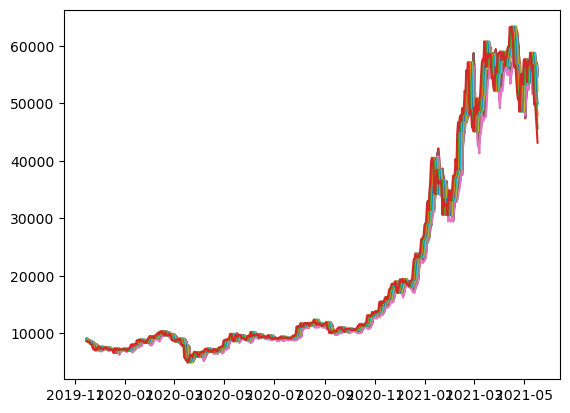

In [231]:
plt.figure()
plt.plot(pd.to_datetime(df['Date'][-len(preds):]), preds)
plt.plot(pd.to_datetime(df['Date'][-len(preds):]), tf.squeeze(test_labels))

### model 5 (LSTM's) --------------------------------

In [233]:
window_size = 7
horizon = 1
full_windows, full_labels = make_windows(price, window_size=window_size, horizon = horizon)
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(full_windows, full_labels)

In [234]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

model5 = Sequential()
model5.add(LSTM(256, activation='relu', input_shape=(window_size, 1)))
# The input_shape is changed to (window_size, 1) to match the input shape of LSTM layer
model5.add(Dense(horizon, activation='linear'))

model5.compile(loss='mae', optimizer='Adam', metrics=['mae'])

# Reshape train_windows and test_windows to add the third dimension for LSTM input
train_windows_reshaped = train_windows.reshape(train_windows.shape[0], train_windows.shape[1], 1)
test_windows_reshaped = test_windows.reshape(test_windows.shape[0], test_windows.shape[1], 1)

model5.fit(train_windows_reshaped, train_labels, 
          epochs=100, verbose=1, 
          batch_size=32, validation_data=(test_windows_reshaped, test_labels),
          callbacks = [create_model_checkpoints(model_name=model5.name)])


Epoch 1/100
70/70 [==============================] - 4s 42ms/step - loss: 590.1838 - mae: 590.1838 - val_loss: 1683.8630 - val_mae: 1683.8630
Epoch 2/100
70/70 [==============================] - 1s 20ms/step - loss: 298.7623 - mae: 298.7623 - val_loss: 2514.8857 - val_mae: 2514.8857
Epoch 3/100
70/70 [==============================] - 3s 37ms/step - loss: 307.5097 - mae: 307.5097 - val_loss: 1520.4789 - val_mae: 1520.4789
Epoch 4/100
70/70 [==============================] - 3s 38ms/step - loss: 291.6912 - mae: 291.6912 - val_loss: 1512.5913 - val_mae: 1512.5913
Epoch 5/100
70/70 [==============================] - 3s 38ms/step - loss: 289.9371 - mae: 289.9371 - val_loss: 1499.4507 - val_mae: 1499.4507
Epoch 6/100
70/70 [==============================] - 3s 38ms/step - loss: 280.1752 - mae: 280.1752 - val_loss: 1464.0028 - val_mae: 1464.0028
Epoch 7/100
70/70 [==============================] - 1s 19ms/step - loss: 283.5210 - mae: 283.5210 - val_loss: 1762.5118 - val_mae: 1762.5118
Epoch 

In [236]:
forecast  = model5.predict(test_windows)
preds =(forecast)
evaluate_preds(y_true= test_labels, y_pred= preds)

18/18 [==============================] - 0s 5ms/step
For mae, mse, rmse and hubber : lower value is better.
mase :- A scaled eror is >1 if the forecast is worse than the naive and <1 if the forecast is better that the naive.

    "mae": 1271.3350830078125,
    "mse": 5265695.0,
    "rmse": 1439.2274169921875,
    "huber_loss": 1270.835205078125,
    "mase": 2.273461103439331
    


{'mae': 1271.3351,
 'mse': 5265695.0,
 'rmse': 1439.2274,
 'huber_loss': 1270.8352,
 'mase': 2.273461}

In [238]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense

# Define input layer
inputs = Input(shape=(window_size, 1))

# Define LSTM layers
lstm1 = LSTM(256, activation='relu', return_sequences=True)(inputs)
lstm2 = LSTM(128, activation='relu')(lstm1)

# Define output layer
outputs = Dense(horizon, activation='linear')(lstm2)

# Create model
model = Model(inputs=inputs, outputs=outputs)

# Compile model
model.compile(loss='mae', optimizer='Adam', metrics=['mae'])

# Reshape train_windows and test_windows to add the third dimension for LSTM input
train_windows_reshaped = train_windows.reshape(train_windows.shape[0], train_windows.shape[1], 1)
test_windows_reshaped = test_windows.reshape(test_windows.shape[0], test_windows.shape[1], 1)

# Train the model
model.fit(train_windows_reshaped, train_labels, 
          epochs=100, verbose=1, 
          batch_size=32, validation_data=(test_windows_reshaped, test_labels),
          callbacks=[create_model_checkpoints(model_name=model.name)])



Epoch 1/100
70/70 [==============================] - 8s 89ms/step - loss: 518.4390 - mae: 518.4390 - val_loss: 1592.0159 - val_mae: 1592.0159
Epoch 2/100
70/70 [==============================] - 3s 42ms/step - loss: 308.6764 - mae: 308.6764 - val_loss: 1684.5736 - val_mae: 1684.5736
Epoch 3/100
70/70 [==============================] - 3s 43ms/step - loss: 320.1093 - mae: 320.1093 - val_loss: 2234.4341 - val_mae: 2234.4341
Epoch 4/100
70/70 [==============================] - 3s 43ms/step - loss: 304.4364 - mae: 304.4364 - val_loss: 1626.2179 - val_mae: 1626.2179
Epoch 5/100
70/70 [==============================] - 5s 76ms/step - loss: 302.2282 - mae: 302.2282 - val_loss: 1563.1666 - val_mae: 1563.1666
Epoch 6/100
70/70 [==============================] - 3s 41ms/step - loss: 307.6320 - mae: 307.6320 - val_loss: 1610.2682 - val_mae: 1610.2682
Epoch 7/100
70/70 [==============================] - 3s 41ms/step - loss: 305.2278 - mae: 305.2278 - val_loss: 1771.6063 - val_mae: 1771.6063
Epoch 

In [240]:
forecast  = model.predict(test_windows)
preds =(forecast)
evaluate_preds(y_true= test_labels, y_pred= preds)

18/18 [==============================] - 0s 7ms/step
For mae, mse, rmse and hubber : lower value is better.
mase :- A scaled eror is >1 if the forecast is worse than the naive and <1 if the forecast is better that the naive.

    "mae": 1166.2696533203125,
    "mse": 4789258.0,
    "rmse": 1342.555908203125,
    "huber_loss": 1165.769775390625,
    "mase": 2.085578203201294
    


{'mae': 1166.2697,
 'mse': 4789258.0,
 'rmse': 1342.5559,
 'huber_loss': 1165.7698,
 'mase': 2.0855782}

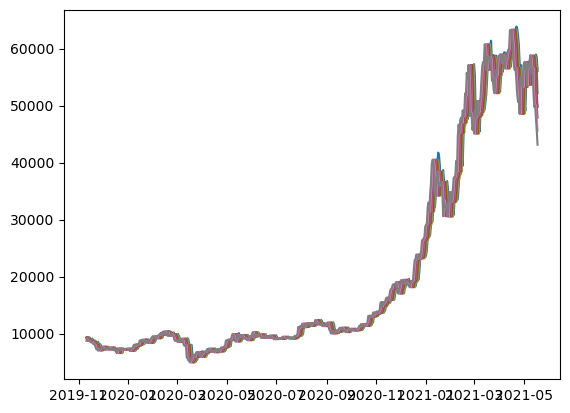

In [241]:
plt.figure()
plt.plot(pd.to_datetime(df['Date'][-len(preds):]), preds)
plt.plot(pd.to_datetime(df['Date'][-len(preds):]), tf.squeeze(test_labels))

### model 7 lstm

In [247]:
import tensorflow as tf
from tensorflow.keras import layers

tf.random.set_seed(33)

inputs = layers.Input(shape=(window_size,))
x = tf.expand_dims(inputs, axis=1)

x = layers.LSTM(256, return_sequences=True, activation='relu')(x)

output = layers.Dense(horizon, activation='linear')(x)
model7 = tf.keras.Model(inputs=inputs, outputs=output, name='model_7_lstm')

model7.compile(loss='mae', optimizer='Adam', metrics=['mae'])

model7.fit(train_windows, train_labels, epochs=100, batch_size=128, 
           validation_data=(test_windows, test_labels),
           callbacks=[create_model_checkpoints(model_name=model7.name)])


Epoch 1/100
18/18 [==============================] - 3s 103ms/step - loss: 2125.6260 - mae: 2125.6260 - val_loss: 7167.5444 - val_mae: 7167.5444
Epoch 2/100
18/18 [==============================] - 2s 91ms/step - loss: 536.1166 - mae: 536.1166 - val_loss: 2049.0464 - val_mae: 2049.0464
Epoch 3/100
18/18 [==============================] - 2s 91ms/step - loss: 296.5824 - mae: 296.5824 - val_loss: 1506.3452 - val_mae: 1506.3452
Epoch 4/100
18/18 [==============================] - 2s 92ms/step - loss: 268.4236 - mae: 268.4236 - val_loss: 1496.0138 - val_mae: 1496.0138
Epoch 5/100
18/18 [==============================] - 2s 94ms/step - loss: 266.8264 - mae: 266.8264 - val_loss: 1452.8334 - val_mae: 1452.8334
Epoch 6/100
18/18 [==============================] - 2s 94ms/step - loss: 264.9858 - mae: 264.9858 - val_loss: 1434.0687 - val_mae: 1434.0687
Epoch 7/100
18/18 [==============================] - 2s 91ms/step - loss: 260.8715 - mae: 260.8715 - val_loss: 1400.7590 - val_mae: 1400.7590
Epo

In [248]:
forecast  = model7.predict(test_windows)
preds =(forecast)
evaluate_preds(y_true= test_labels, y_pred= preds)

18/18 [==============================] - 0s 3ms/step
For mae, mse, rmse and hubber : lower value is better.
mase :- A scaled eror is >1 if the forecast is worse than the naive and <1 if the forecast is better that the naive.

    "mae": 16805.7265625,
    "mse": 600412416.0,
    "rmse": 16854.052734375,
    "huber_loss": 1210.305908203125,
    "mase": 30.052791595458984
    


{'mae': 16805.727,
 'mse': 600412400.0,
 'rmse': 16854.053,
 'huber_loss': 1210.3059,
 'mase': 30.052792}

### model 8 : lstm deep model (window - 7 , horizon = 1)

In [261]:
window_size = 7
horizon = 1
full_windows, full_labels = make_windows(price, window_size=window_size, horizon = horizon)
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(full_windows, full_labels)

In [262]:
train_windows.shape, test_windows.shape, train_labels.shape, test_labels.shape

((2224, 7), (556, 7), (2224, 1), (556, 1))

In [263]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, BatchNormalization

# Define input layer
inputs = Input(shape=(window_size, 1))

# Define LSTM layers with dropout and batch normalization
lstm1 = LSTM(256, activation='relu', return_sequences=True)(inputs)
# dropout1 = Dropout(0.25)(lstm1)  # Adding dropout layer
# batchnorm1 = BatchNormalization()(dropout1)  # Adding batch normalization layer

lstm2 = LSTM(128, activation='relu',return_sequences=True)(lstm1)
# dropout2 = Dropout(0.25)(lstm2)  # Adding dropout layer
# batchnorm2 = BatchNormalization()(dropout2)  # Adding batch normalization layer

lstm3 = LSTM(128, activation='relu')(lstm2)

outputs = Dense(horizon, activation='linear')(lstm3)

# Create model
model = Model(inputs=inputs, outputs=outputs)

# Compile model
model.compile(loss='mae', optimizer='Adam', metrics=['mae'])

# Reshape train_windows and test_windows to add the third dimension for LSTM input
train_windows_reshaped = train_windows.reshape(train_windows.shape[0], train_windows.shape[1], 1)
test_windows_reshaped = test_windows.reshape(test_windows.shape[0], test_windows.shape[1], 1)

# Train the model
model.fit(train_windows_reshaped, train_labels, 
          epochs=100, verbose=1, 
          batch_size=32, validation_data=(test_windows_reshaped, test_labels),
          callbacks=[create_model_checkpoints(model_name=model.name)])



Epoch 1/100
70/70 [==============================] - 10s 107ms/step - loss: 814.8041 - mae: 814.8041 - val_loss: 1328.4554 - val_mae: 1328.4554
Epoch 2/100
70/70 [==============================] - 4s 63ms/step - loss: 265.8674 - mae: 265.8674 - val_loss: 1472.9368 - val_mae: 1472.9368
Epoch 3/100
70/70 [==============================] - 4s 56ms/step - loss: 253.7865 - mae: 253.7865 - val_loss: 1393.8735 - val_mae: 1393.8735
Epoch 4/100
70/70 [==============================] - 4s 55ms/step - loss: 264.5571 - mae: 264.5571 - val_loss: 1340.2721 - val_mae: 1340.2721
Epoch 5/100
70/70 [==============================] - 4s 60ms/step - loss: 253.2994 - mae: 253.2994 - val_loss: 1554.8984 - val_mae: 1554.8984
Epoch 6/100
70/70 [==============================] - 4s 56ms/step - loss: 242.0013 - mae: 242.0013 - val_loss: 1365.7150 - val_mae: 1365.7150
Epoch 7/100
70/70 [==============================] - 4s 56ms/step - loss: 243.2034 - mae: 243.2034 - val_loss: 1368.4169 - val_mae: 1368.4169
Epoc

In [270]:
model.name

'model_3'

In [264]:
forecast  = model.predict(test_windows)
preds =(forecast)
evaluate_preds(y_true= test_labels, y_pred= preds)

18/18 [==============================] - 0s 8ms/step
For mae, mse, rmse and hubber : lower value is better.
mase :- A scaled eror is >1 if the forecast is worse than the naive and <1 if the forecast is better that the naive.

    "mae": 572.3238525390625,
    "mse": 1153974.875,
    "rmse": 572.3238525390625,
    "huber_loss": 571.8240966796875,
    "mase": 1.0054144859313965
    


{'mae': 572.32385,
 'mse': 1153974.9,
 'rmse': 572.32385,
 'huber_loss': 571.8241,
 'mase': 1.0054145}

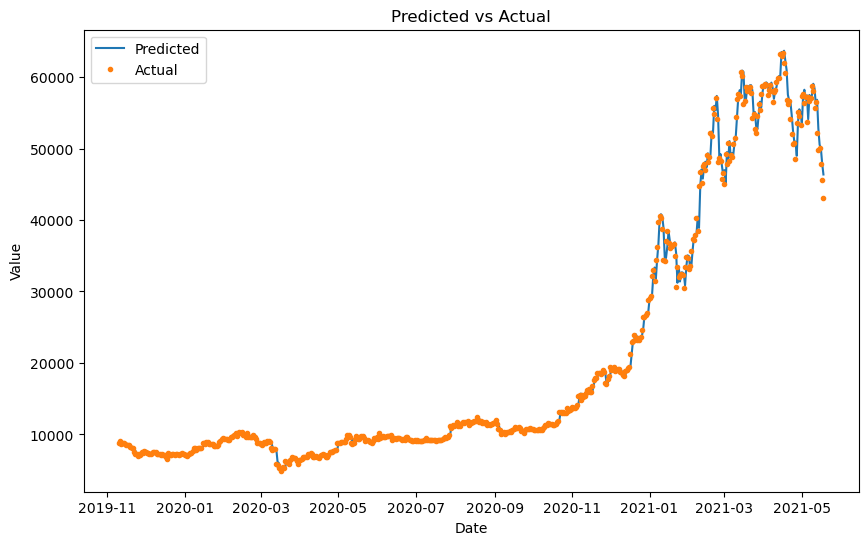

In [269]:
plt.figure(figsize=(10, 6))  # Adjust size as needed
plt.plot(pd.to_datetime(df['Date'][-len(preds):]), preds, label='Predicted')
plt.plot(pd.to_datetime(df['Date'][-len(preds):]), tf.squeeze(test_labels), label='Actual',linestyle = " ", marker='.')
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Predicted vs Actual')
plt.legend()
plt.show()


In [271]:
import tensorflow as tf

# Assuming the model is saved with the name 'model_name'
model_path = 'D:\Time_series_project\model_experiments\model_3'  # Replace 'path_to_saved_model' with the actual path

# Load the saved model
loaded_model = tf.keras.models.load_model(model_path)

# Now 'loaded_model' contains the saved model and you can use it for predictions or further training


In [272]:
forecast  = loaded_model.predict(test_windows)
preds =(forecast)
evaluate_preds(y_true= test_labels, y_pred= preds)

18/18 [==============================] - 1s 13ms/step
For mae, mse, rmse and hubber : lower value is better.
mase :- A scaled eror is >1 if the forecast is worse than the naive and <1 if the forecast is better that the naive.

    "mae": 564.5558471679688,
    "mse": 1134711.625,
    "rmse": 564.5558471679688,
    "huber_loss": 564.0560913085938,
    "mase": 0.9917682409286499
    


{'mae': 564.55585,
 'mse': 1134711.6,
 'rmse': 564.55585,
 'huber_loss': 564.0561,
 'mase': 0.99176824}

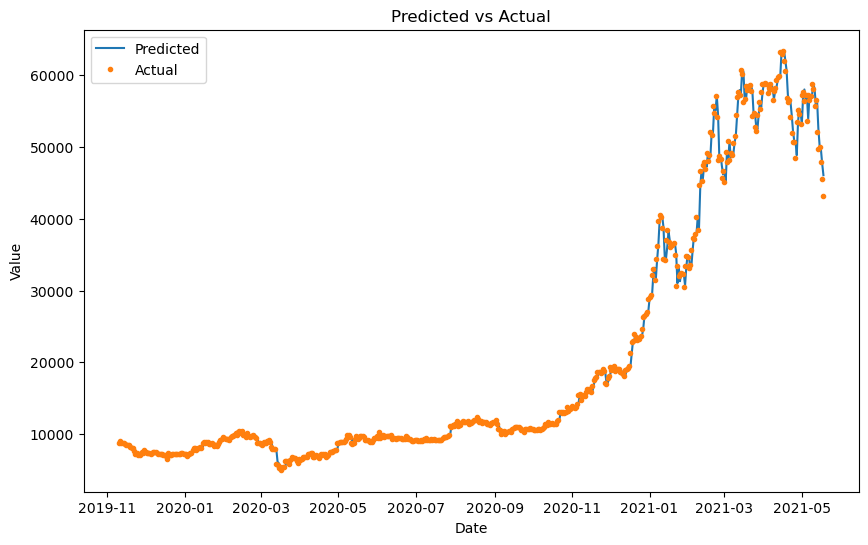

In [273]:
plt.figure(figsize=(10, 6))  # Adjust size as needed
plt.plot(pd.to_datetime(df['Date'][-len(preds):]), preds, label='Predicted')
plt.plot(pd.to_datetime(df['Date'][-len(preds):]), tf.squeeze(test_labels), label='Actual',linestyle = " ", marker='.')
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Predicted vs Actual')
plt.legend()
plt.show()

In [276]:
# data = pd.read_csv("D:\Time_series_project\BTC-USD.csv",parse_dates=['Date'])
data.info()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3480 entries, 2014-09-17 to 2024-03-27
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       3480 non-null   float64
 1   High       3480 non-null   float64
 2   Low        3480 non-null   float64
 3   Close      3480 non-null   float64
 4   Adj Close  3480 non-null   float64
 5   Volume     3480 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 190.3 KB


In [275]:
data.set_index("Date", inplace=True)

In [277]:
bitcoin_price_1 = pd.DataFrame(data['Adj Close']).rename(columns = {'Adj Close': 'PRice'})
timestemp_1 = bitcoin_price_1.index.to_numpy()
price_1 = bitcoin_price_1['PRice'].to_numpy()
timestamp_1 = pd.to_datetime(timestemp_1)

In [282]:
window_size = 7
horizon = 1
full_windows, full_labels = make_windows(price_1, window_size=window_size, horizon = horizon)
forecast  = loaded_model.predict(full_windows)
preds =(forecast)
evaluate_preds(y_true= full_labels, y_pred= preds)

 10/109 [=>............................] - ETA: 1s

109/109 [==============================] - 1s 8ms/step
For mae, mse, rmse and hubber : lower value is better.
mase :- A scaled eror is >1 if the forecast is worse than the naive and <1 if the forecast is better that the naive.

    "mae": 387.3293151855469,
    "mse": 679252.375,
    "rmse": 387.3293151855469,
    "huber_loss": 386.8358459472656,
    "mase": 0.9963200092315674
    


{'mae': 387.3293,
 'mse': 679252.4,
 'rmse': 387.3293,
 'huber_loss': 386.83585,
 'mase': 0.99632}

In [283]:
timestemp_1.shape, (tf.squeeze(full_labels)).shape, preds.shape

((3480,), TensorShape([3473]), (3473, 1))

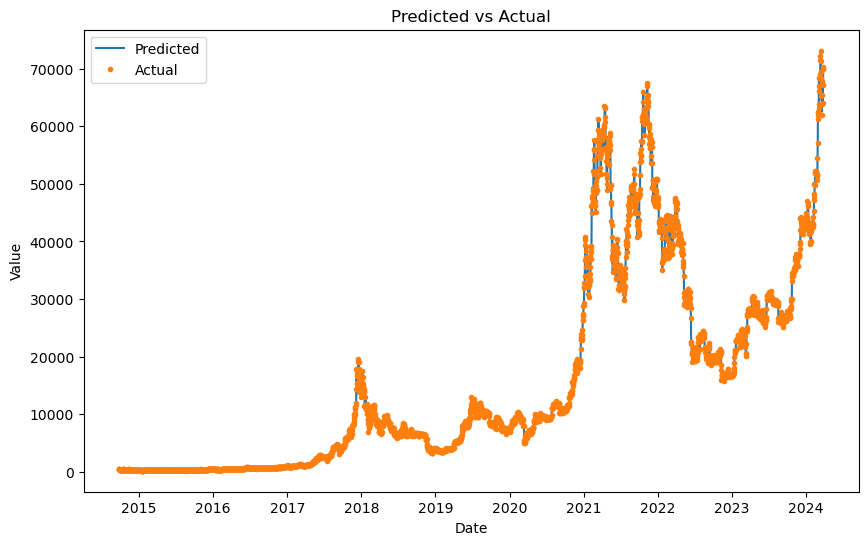

In [285]:
plt.figure(figsize=(10, 6))  # Adjust size as needed
plt.plot(timestemp_1[7:], preds, label='Predicted')
plt.plot(timestemp_1[7:], tf.squeeze(full_labels), label='Actual',linestyle = " ", marker='.')
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Predicted vs Actual')
plt.legend()
plt.show()

In [331]:
x= list(timestemp_1[7:])
y = (list(preds))
values = [item[0] for item in y]

z = list(tf.squeeze(full_labels).numpy())
df_onix = pd.DataFrame({'x':x, 'y':values, 'z':z})
df_onix['x']=pd.to_datetime(df_onix['x'])

df_onix.head()

,x,y,z
0,2014-09-24,435.859406,423.204987
1,2014-09-25,426.545013,411.574005
2,2014-09-26,412.727600,404.424988
3,2014-09-27,404.766327,399.519989
4,2014-09-28,400.804047,377.181000


In [332]:
import plotly.graph_objects as go

# Assuming df_final is your DataFrame
# Create a Plotly figure
fig = go.Figure()

# Add traces for 'Appliances' and 'App_Pred'
fig.add_trace(go.Scatter(x=df_onix['x'], y=df_onix['y'], mode='lines', name='Appliances'))
fig.add_trace(go.Scatter(x=df_onix['x'], y=df_onix['z'], mode='lines', name='App_Pred'))

# Update layout with titles and labels
fig.update_layout(title='Appliances vs. App_Pred',
                  xaxis_title='Time',
                  yaxis_title='Value',
                  xaxis=dict(rangeslider=dict(visible=True)))  # Add range slider

# Show the plot
fig.show()

### model 9 

In [336]:
window_size = 30
horizon = 7
full_windows, full_labels = make_windows(price, window_size=window_size, horizon = horizon)
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(full_windows, full_labels)

In [337]:
train_windows.shape, test_windows.shape, train_labels.shape, test_labels.shape

((2200, 30), (551, 30), (2200, 7), (551, 7))

In [338]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, BatchNormalization

# Define input layer
inputs = Input(shape=(window_size, 1))

# Define LSTM layers with dropout and batch normalization
lstm1 = LSTM(256, activation='relu', return_sequences=True)(inputs)
# dropout1 = Dropout(0.25)(lstm1)  # Adding dropout layer
# batchnorm1 = BatchNormalization()(dropout1)  # Adding batch normalization layer

lstm2 = LSTM(128, activation='relu',return_sequences=True)(lstm1)
# dropout2 = Dropout(0.25)(lstm2)  # Adding dropout layer
# batchnorm2 = BatchNormalization()(dropout2)  # Adding batch normalization layer

lstm3 = LSTM(128, activation='relu')(lstm2)

outputs = Dense(horizon, activation='linear')(lstm3)

# Create model
model9 = Model(inputs=inputs, outputs=outputs, name = 'model_9')

# Compile model
model9.compile(loss='mae', optimizer='Adam', metrics=['mae'])

# Reshape train_windows and test_windows to add the third dimension for LSTM input
train_windows_reshaped = train_windows.reshape(train_windows.shape[0], train_windows.shape[1], 1)
test_windows_reshaped = test_windows.reshape(test_windows.shape[0], test_windows.shape[1], 1)

# Train the model
model9.fit(train_windows_reshaped, train_labels, 
          epochs=100, verbose=1, 
          batch_size=32, validation_data=(test_windows_reshaped, test_labels),
          callbacks=[create_model_checkpoints(model_name=model9.name)])


Epoch 1/100
69/69 [==============================] - 23s 301ms/step - loss: 2631.8235 - mae: 2631.8235 - val_loss: 12213.4834 - val_mae: 12213.4834
Epoch 2/100
69/69 [==============================] - 17s 248ms/step - loss: 9680.4502 - mae: 9680.4502 - val_loss: 23362.5254 - val_mae: 23362.5254
Epoch 3/100
69/69 [==============================] - 21s 304ms/step - loss: 4210.4292 - mae: 4210.4292 - val_loss: 9426.1895 - val_mae: 9426.1895
Epoch 4/100
69/69 [==============================] - 18s 256ms/step - loss: 1283.3423 - mae: 1283.3423 - val_loss: 5236.7026 - val_mae: 5236.7026
Epoch 5/100
69/69 [==============================] - 20s 286ms/step - loss: 709.4136 - mae: 709.4136 - val_loss: 3640.5811 - val_mae: 3640.5811
Epoch 6/100
69/69 [==============================] - 16s 233ms/step - loss: 932.5380 - mae: 932.5380 - val_loss: 4814.3755 - val_mae: 4814.3755
Epoch 7/100
69/69 [==============================] - 16s 237ms/step - loss: 1216.5161 - mae: 1216.5161 - val_loss: 15928.230

In [339]:
import tensorflow as tf

# Assuming the model is saved with the name 'model_name'
model_path = 'D:\Time_series_project\model_experiments\model_9'  # Replace 'path_to_saved_model' with the actual path

# Load the saved model
loaded_model_9 = tf.keras.models.load_model(model_path)

# Now 'loaded_model' contains the saved model and you can use it for predictions or further training

In [340]:
forecast  = loaded_model_9.predict(test_windows)
preds =(forecast)
evaluate_preds(y_true= test_labels, y_pred= preds)

18/18 [==============================] - 1s 34ms/step
For mae, mse, rmse and hubber : lower value is better.
mase :- A scaled eror is >1 if the forecast is worse than the naive and <1 if the forecast is better that the naive.

    "mae": 2406.656982421875,
    "mse": 17005124.0,
    "rmse": 2563.940673828125,
    "huber_loss": 2406.1572265625,
    "mase": 4.282511234283447
    


{'mae': 2406.657,
 'mse': 17005124.0,
 'rmse': 2563.9407,
 'huber_loss': 2406.1572,
 'mase': 4.282511}

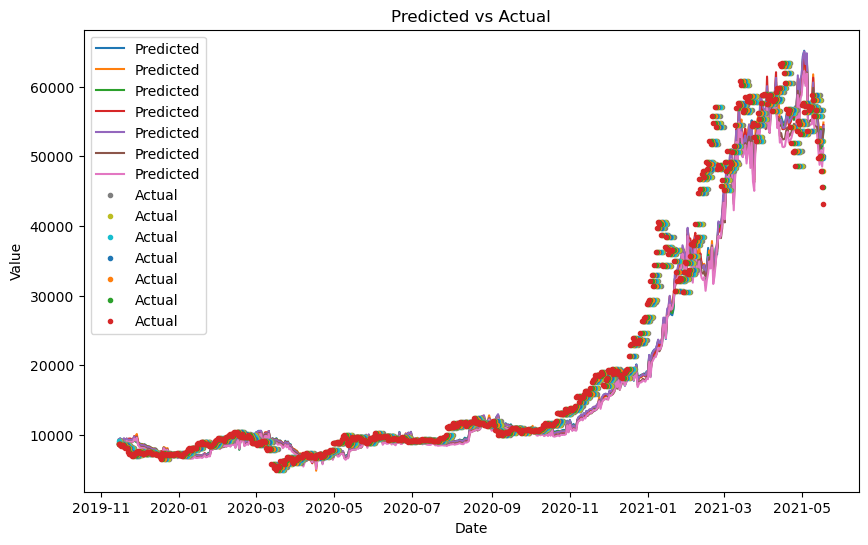

In [341]:
plt.figure(figsize=(10, 6))  # Adjust size as needed
plt.plot(pd.to_datetime(df['Date'][-len(preds):]), preds, label='Predicted')
plt.plot(pd.to_datetime(df['Date'][-len(preds):]), tf.squeeze(test_labels), label='Actual',linestyle = " ", marker='.')
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Predicted vs Actual')
plt.legend()
plt.show()

In [342]:
window_size = 30
horizon = 7
full_windows, full_labels = make_windows(price_1, window_size=window_size, horizon = horizon)
forecast  = loaded_model_9.predict(full_windows)
preds =(forecast)
evaluate_preds(y_true= full_labels, y_pred= preds)

108/108 [==============================] - 3s 25ms/step
For mae, mse, rmse and hubber : lower value is better.
mase :- A scaled eror is >1 if the forecast is worse than the naive and <1 if the forecast is better that the naive.

    "mae": 1806.6470947265625,
    "mse": 11834733.0,
    "rmse": 1915.679443359375,
    "huber_loss": 1806.148193359375,
    "mase": 4.62106466293335
    


{'mae': 1806.6471,
 'mse': 11834733.0,
 'rmse': 1915.6794,
 'huber_loss': 1806.1482,
 'mase': 4.6210647}

In [352]:
forecast_1 = pd.DataFrame(forecast)
forecast_1['final _result'] = (forecast_1[0]+ forecast_1[1]+ forecast_1[2]+ forecast_1[3]+ forecast_1[4]+ forecast_1[5]+ forecast_1[6])/7

In [353]:
full_labels

array([[  383.757996,   391.441986,   389.54599 , ...,   386.475006,
          383.15799 ,   358.416992],
       [  391.441986,   389.54599 ,   382.845001, ...,   383.15799 ,
          358.416992,   358.345001],
       [  389.54599 ,   382.845001,   386.475006, ...,   358.416992,
          358.345001,   347.270996],
       ...,
       [61912.773438, 67913.671875, 65491.390625, ..., 64062.203125,
        67234.171875, 69958.8125  ],
       [67913.671875, 65491.390625, 63778.761719, ..., 67234.171875,
        69958.8125  , 69987.835938],
       [65491.390625, 63778.761719, 64062.203125, ..., 69958.8125  ,
        69987.835938, 70208.960938]])